# Obdelava podatkov iz kamere Astra

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import math
import statistics 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


Pripravimo knjižnjice in dodamo funkcije za lažje obdelavo podatkov. Začnemo s tem, da iz csv datoteke ločimo telesi in si za njiju pripravimo barve
Pripravimo si še funkcije za prikazovanje grafov ter za pretvorbo podatkov v pythonove tipe

Ker sta za nas pomembna le roki bomo iz skeleta odstranili ostale dele telesa. Uporabljali bomo le tabelo koordinat zapestij.

In [2]:
fps = (29.5)  # essentially constant so it's a waste to read from table

def prepare_tables(table):
    """
    Separates the table into 2 data dictionaries, one for each body.
    """
    first_body = table.bodyid[0]  # identify the first and second id
    second_body = table.bodyid[1]
    first_body_table = table[table.bodyid == first_body]  # filter the table for the ids
    second_body_table = table[table.bodyid == second_body]
    return (first_body_table.to_dict(), second_body_table.to_dict())

def colours(which):
    if which:
        return ("limegreen", "darkgreen")
    return ("lightcoral", "darkred")

In [3]:
def plot_arr(chart, part_arr, colour):
    # Separate coordinates and plot them
    part_x = [x[0] for x in part_arr]
    part_y = [y[1] for y in part_arr]
    part_z = [z[2] for z in part_arr]
    chart.plot(xs=part_x, ys=part_y, zs=part_z, color=colour)

def str_to_array(string, dictable):
    # return a column as an array
    import ast
    itm = dictable[string]
    all_pos = [None] * len(itm)
    # We use items() to append in a correct order
    for k, v in itm.items():
        all_pos[k // 2] = ast.literal_eval(v)  # to convert strings to array
    return list(all_pos)

def coordinates_to_arr(coordinates):
    lr_arr = str_to_array("LeftHand", coordinates)
    dr_arr = str_to_array("RightHand", coordinates)
            
    return (lr_arr, dr_arr)

def body_to_pairs(fst, snd):
    fst_lh, fst_rh = coordinates_to_arr(fst)
    snd_lh, snd_rh = coordinates_to_arr(snd)
    fst_updated = ([],[]) 
    snd_updated = ([],[])
    # [0,0,0] represents faulty positions. We just remove them as they are rare
    # and don't lose much due to continuity of the curve
    # It is important we remove them from both so that timed events match up!
    for frame in range(len(fst_lh) - 1):
        if (fst_lh[frame] != [0,0,0] and fst_rh[frame] != [0,0,0]
                and snd_lh[frame] != [0,0,0] and snd_rh[frame] != [0,0,0]):
            fst_updated[0].append(fst_lh[frame])
            fst_updated[1].append(fst_rh[frame])
            snd_updated[0].append(snd_lh[frame])
            snd_updated[1].append(snd_rh[frame])
    return (fst_updated, snd_updated)
    

def draw_relevant(plotter, coordinates, scheme):
    sc_l, sc_r = colours(scheme)
    lr_arr, dr_arr = coordinates_to_arr(coordinates)
    plot_arr(ax1, lr_arr, sc_l)
    plot_arr(ax1, dr_arr, sc_r)

Brali bomo iz mape "csv_dataset". Lahko se osredotočimo na posamezno datoteko ali pa analizo izvedemo na vseh. Zaradi preglednosti bomo gledali le eno datoteko.

Začnemo z izrisom 3D grafa koordinat. Tako vidimo pot rok ob poskusu. Telesi obarvamo z različno barvo, roki pa razlikujemo glede na odtenek barve.

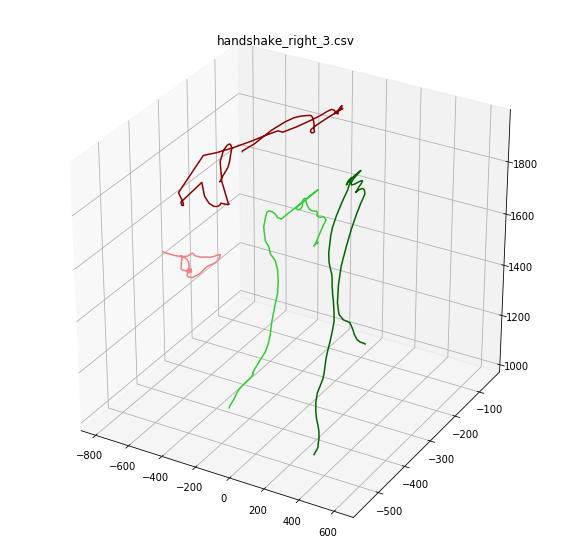

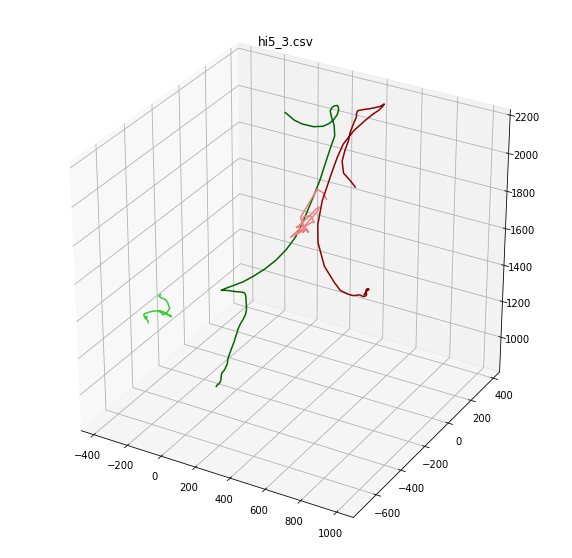

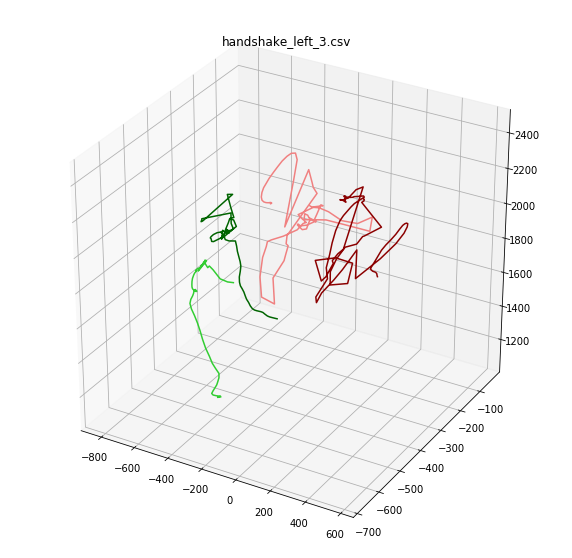

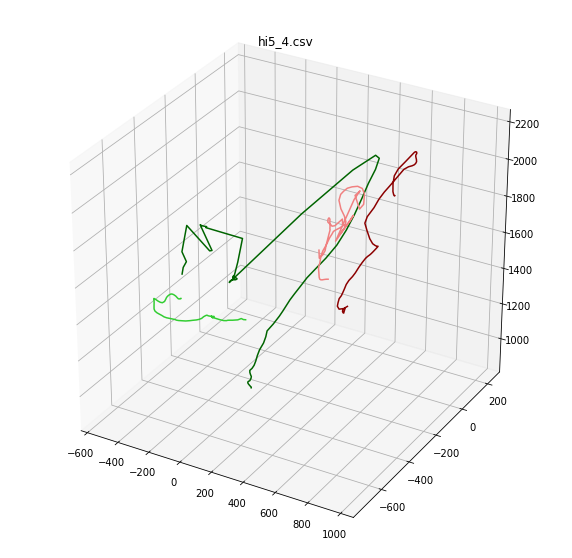

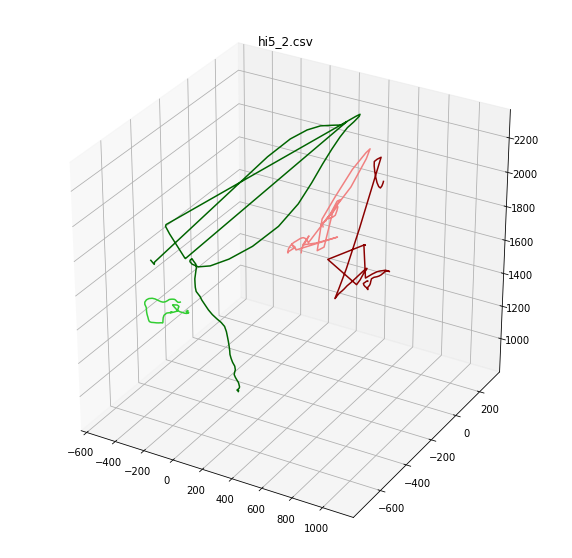

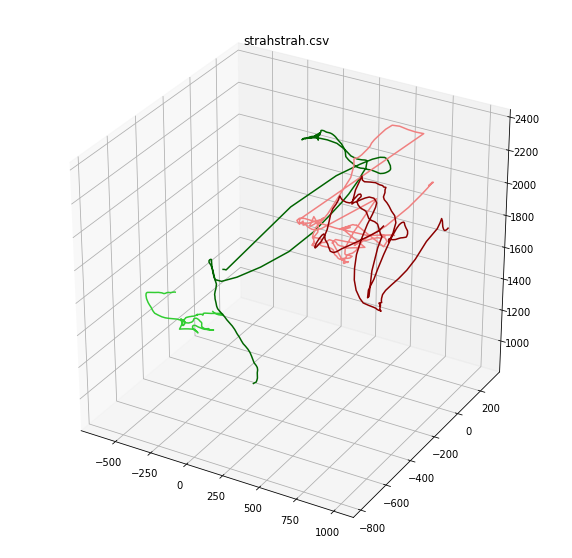

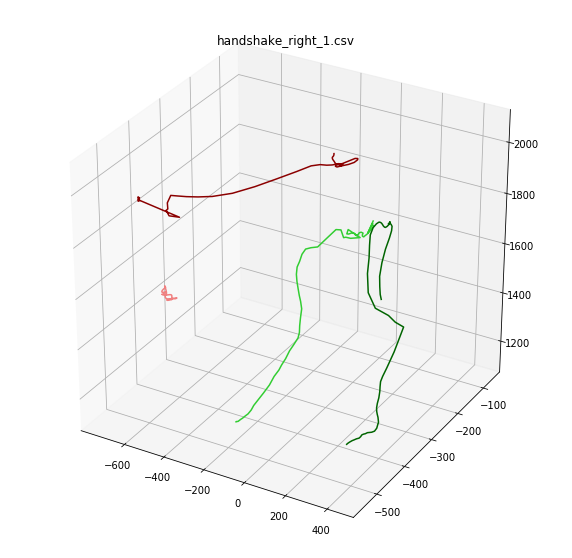

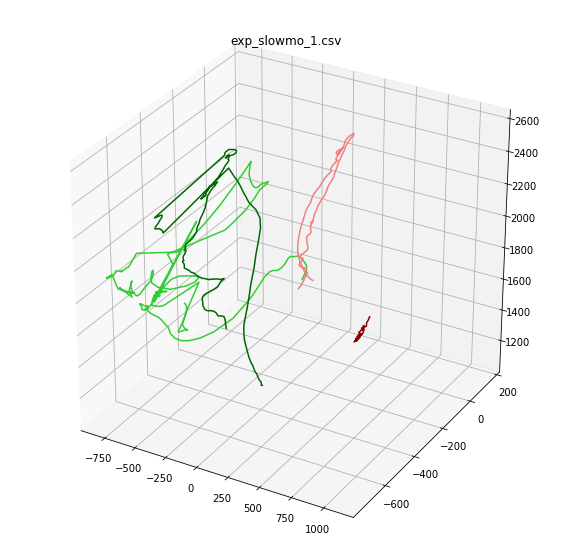

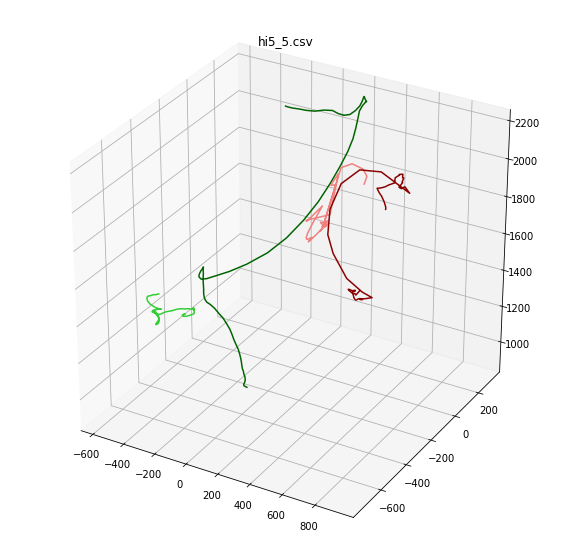

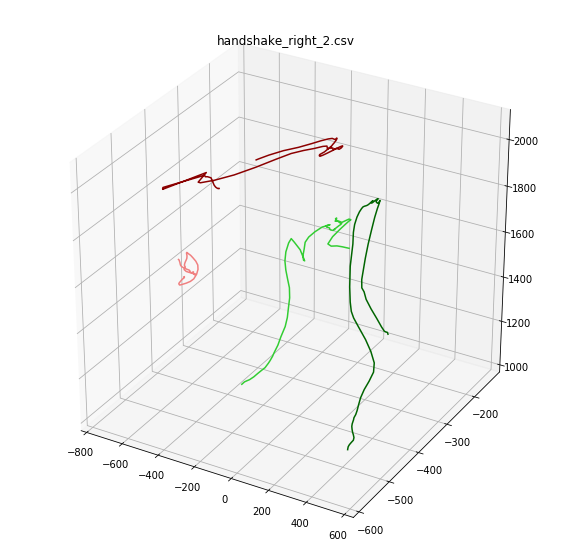

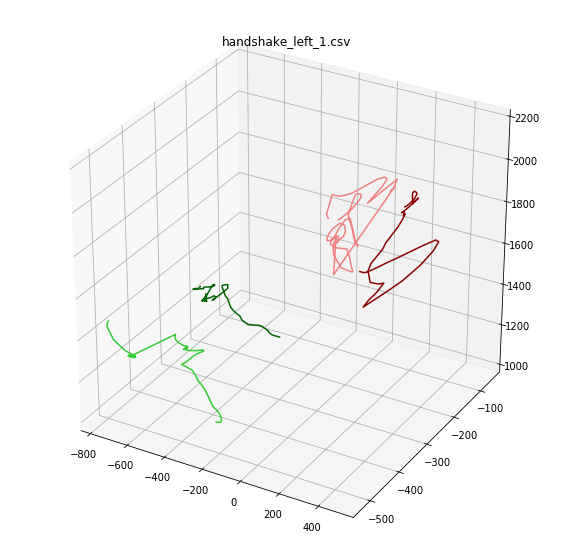

In [8]:
import os

%matplotlib inline

instances = []

list_of_files = os.listdir("csv_dataset")
#list_of_files = [list_of_files[0]] # uncomment to test single file

# For doing to all files
for file in list_of_files:
    table = pd.read_csv(os.path.join("csv_dataset", file))
    fst, snd = prepare_tables(table)
    instances.append( body_to_pairs(fst,snd))
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.set_title(file)

    draw_relevant(ax1, fst, True)
    draw_relevant(ax1, snd, False)


Iščemo najkrajšo razdaljo telesoma. Uporabljamo vgrajene Astrine enote in ne potrebujemo pretvarjanja v metrični sistem, ker dobljene rezultate uporabljamo z Astro. Za občutek, 1000 enot je približno 1 meter.

Najprej preverimo kolikšna je najmanjša razdalja med dvema krivuljama, nato preverimo kolikšna je najmanjša razdalja med krivuljama ob istem času. Predvidevamo, da se bosta ta trenutka približno ujemala. To opazimo tako, da bo razlika med razdaljama majhna.

In [9]:
def euclidean_norm_sq(a, b):
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2

def euclidean_norm(a, b):
    return math.sqrt(euclidean_norm_sq(a,b))

def shortest_distance_between_curves(first_body, second_body):
    dist = 99999999 # distances are only 1000ish apart
    for body_part1 in first_body:
        for body_part2 in second_body:
            for coor1 in body_part1:
                for coor2 in body_part2:
                    dist = min(dist, euclidean_norm_sq(coor1, coor2))
                    
    return dist

def shortest_distance(first_body, second_body):
    dist = 99999999 # distances are only 1000ish apart
    closest_frame = 0
    for body_part1 in first_body:
        for body_part2 in second_body:
            for frame, coor1 in enumerate(body_part1):
                dist_n = euclidean_norm_sq(coor1, body_part2[frame])
                if dist_n < dist:
                    dist = dist_n
                    closest_frame = frame
    return dist, closest_frame

closest_event = []

delta_distances = []

for (a,b) in instances:
    absolute_shortest = shortest_distance_between_curves(a,b)
    timed_shortest, frame = shortest_distance(a,b)
    delta_distances.append(
        abs(math.sqrt(absolute_shortest) - math.sqrt(timed_shortest)))
    closest_event.append(frame)
print(statistics.mean(delta_distances))
if len(delta_distances) > 1:
    print(statistics.stdev(delta_distances))

84.89415578651034
75.12427869741842


Dobimo kar majhno vrednost zamika, le nekaj centimetrov vendar pa iz standardnega odklona vidimo, da se vrednosti kar precej razlikujejo

Narišemo graf hitrosti. Zaradi manjših motenj ima graf lahko velike skoke, zato se omejimo na območje kjer so rezultati v normalnih območjih. Na graf narišemo še navpično črto, ki označi kdaj so bile roke najbližje. Predvidevamo, da bo hitrost tam majhna.

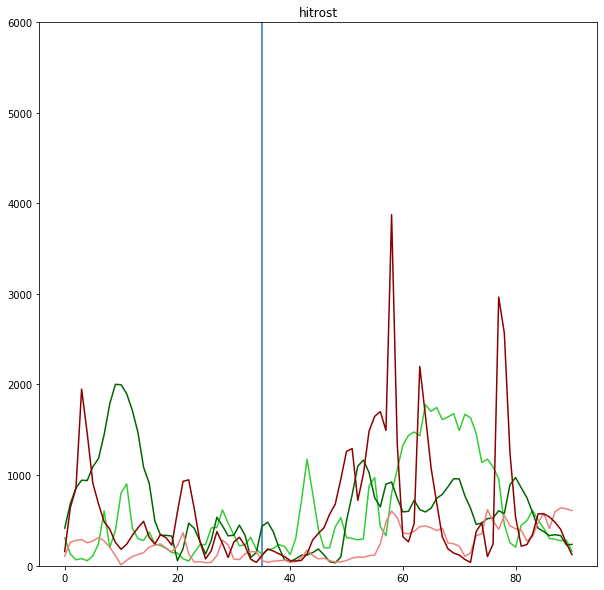

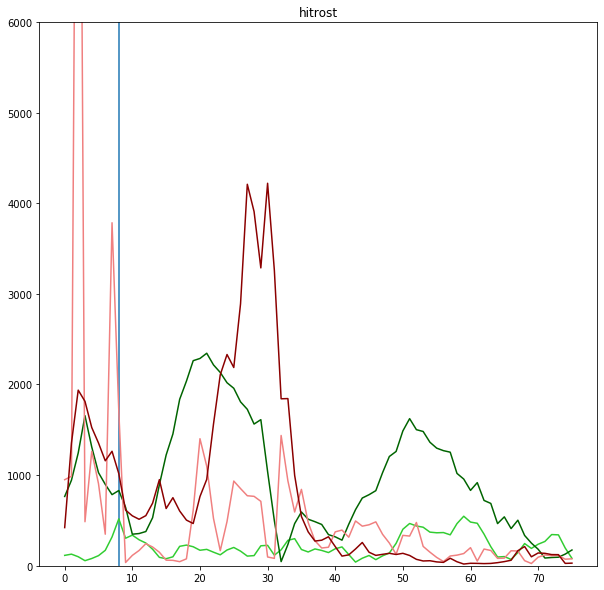

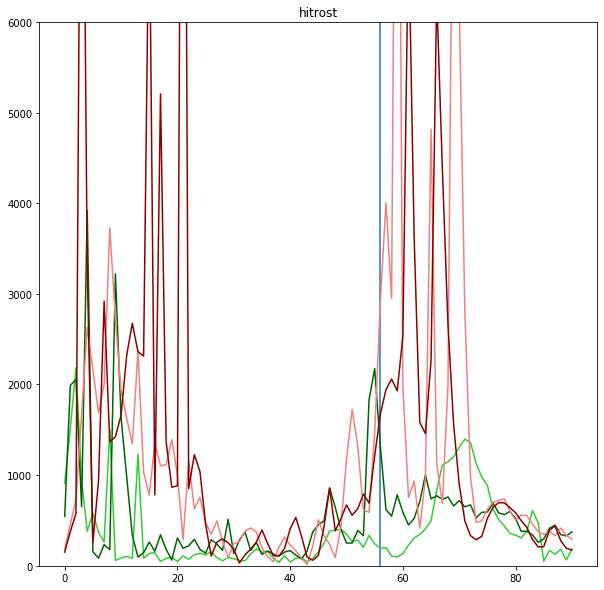

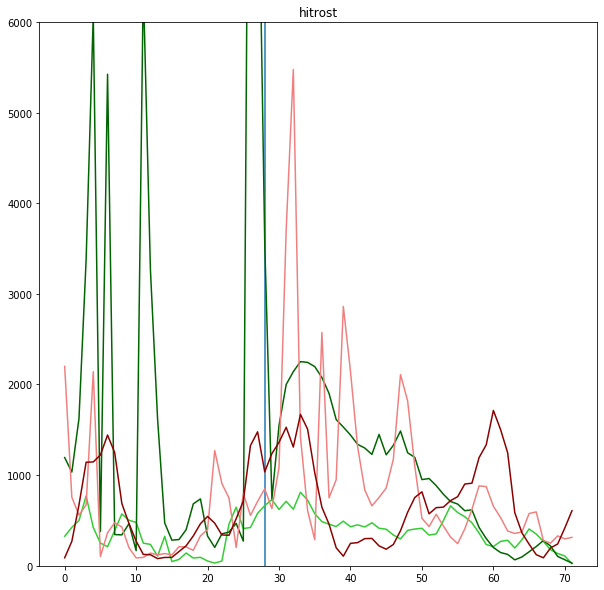

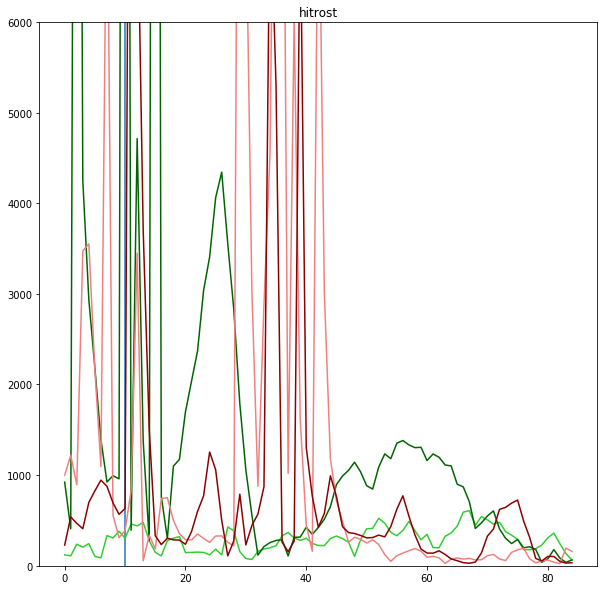

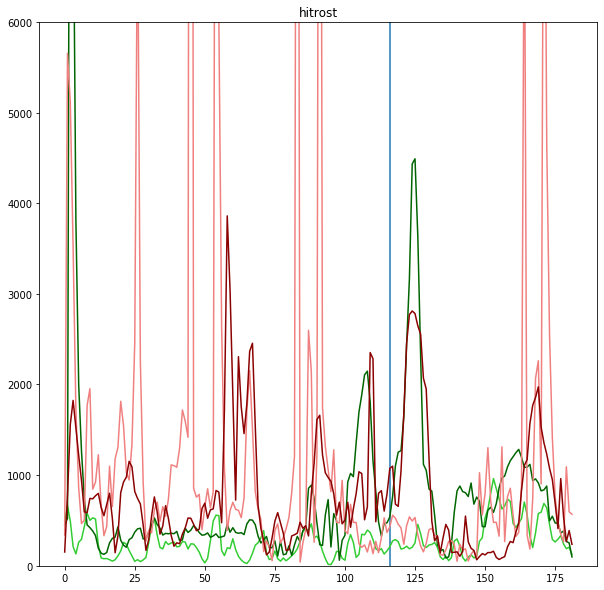

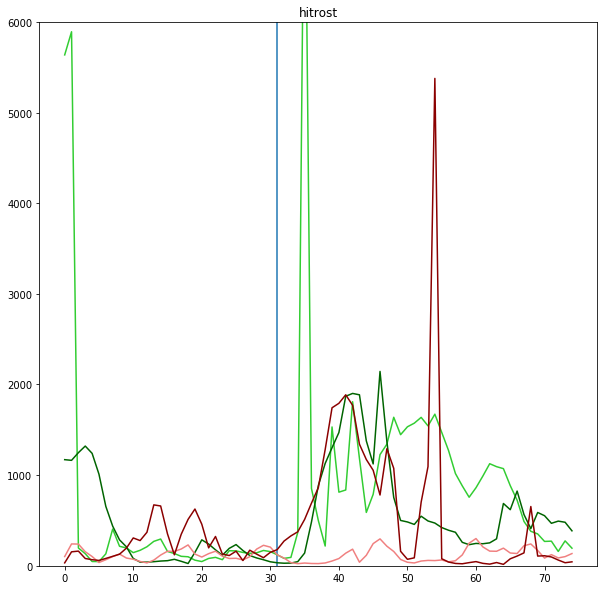

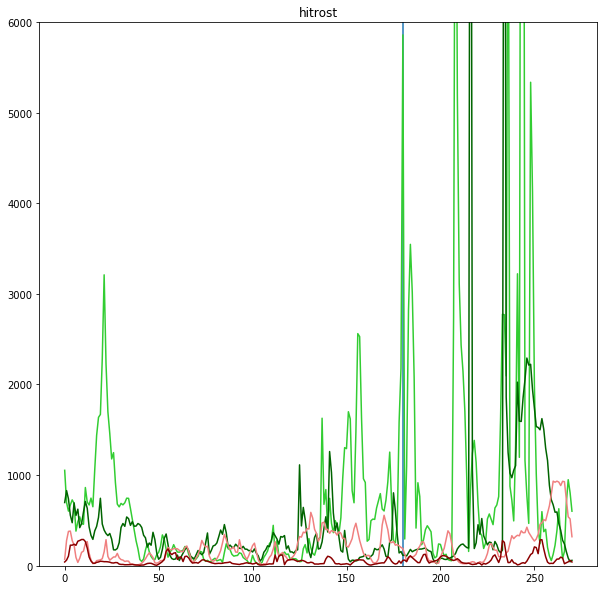

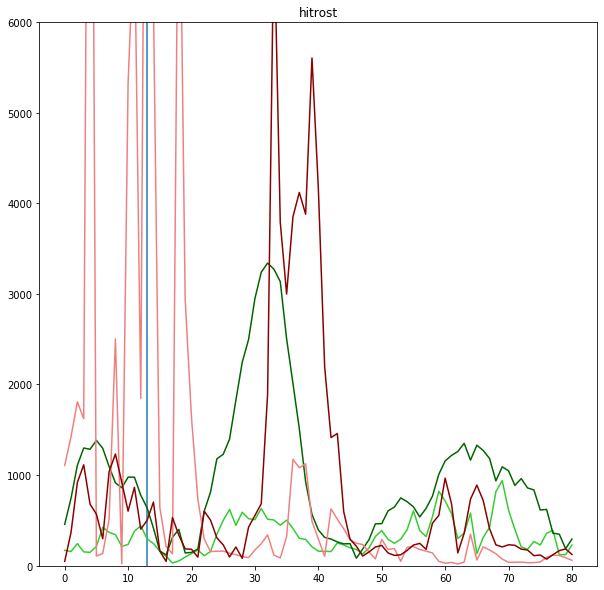

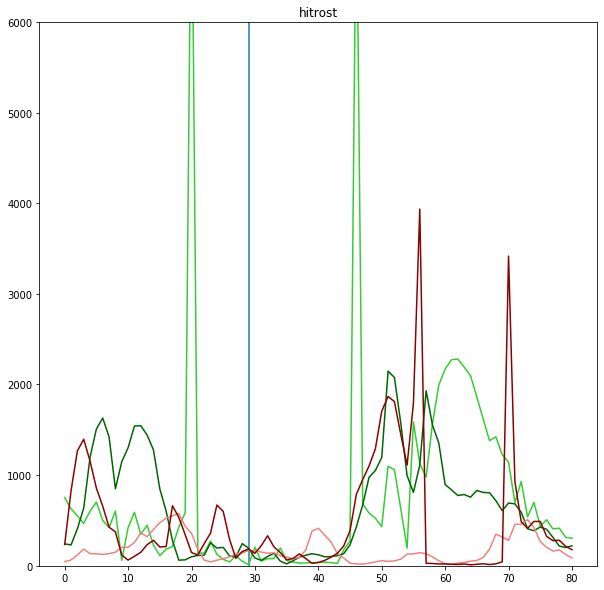

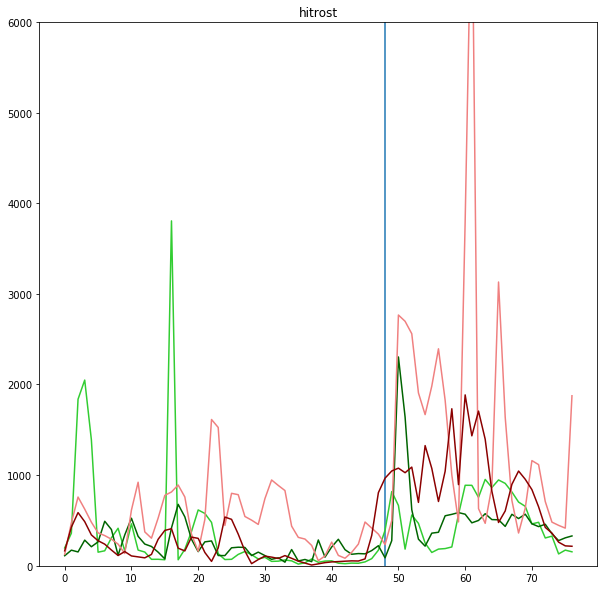

In [10]:
def iterate_pair(arr):
    i = 0
    while i < len(arr) - 1:
        yield (arr[i], arr[i+1])
        i += 1
        

def speed(body_part, fps):
    return [euclidean_norm(a,b) * fps for (a, b) in iterate_pair(body_part)]


for frame, (a,b) in enumerate(instances):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.set_title("hitrost")
    ax1.set_ylim(-2, 6000)
    ax1.axvline(x=closest_event[frame])
    colour = lambda x: colours(True)[x]
    for i, body_part in enumerate(a):
        ax1.plot(speed(body_part, fps), color=colour(i))
    colour = lambda x: colours(False)[x]
    for i, body_part in enumerate(b):
        ax1.plot(speed(body_part, fps), color=colour(i))

Iz grafov vidimo, da je situacija precej kaotična ter ne moremo razbrati, ali hitrost vpliva na razdaljo. To je verjetno posledica nenatančnega zajema podatkov.